# Project 1 - Analysis of Canadian Banks

## Import Python Libraries

In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

False

In [3]:
#pip install -i https://pypi.anaconda.org/ranaroussi/simple yfinance

## Load Data

### 1. Read CSV

In [4]:
# Use the Pathlib libary to set the path to the CSV
# CAD Banks
bmo_path = Path("../data/BMO_Close_Jan2016-Jun2022.csv")
bns_path = Path("../data/BNS_Close_Jan2016-Jun2022.csv")
cm_path = Path("../data/CM_Close_Jan2016-Jun2022.csv")
na_path = Path("../data/NA_Close_Jan2016-Jun2022.csv")
ry_path = Path("../data/RY_Close_Jan2016-Jun2022.csv")
td_path = Path("../data/TD_Close_Jan2016-Jun2022.csv")

#CAD Bank ETF
zeb_path = Path("../data/ZEB_Close_Jan2016-Jun2022.csv")
zgb_path = Path("../data/ZGB_Close_Jan2016-Jun2022.csv")
zwb_path = Path("../data/ZWB_Close_Jan2016-Jun2022.csv")

# Commodities
cd_path = Path("../data/CD_10Year.txt")
cl_path = Path("../data/CL_10Year.txt")
dx_path = Path("../data/DX_10Year.txt")


### 2. Yahoo Finance API

In [5]:
# List the ticker symbols for the stocks of interest
lst=['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]


# Determine the start and end dates
start_date = '2016-08-01'
end_date = '2019-07-31'

# Create empty dataframe to hold stock data
dfAllStocks_Train=pd.DataFrame()

# Gathers stock data from listed tickers and combines them into a dataframe
for ticker in lst:
    # Create data frame from API in loop 
    df= yf.download(ticker, start= start_date, end= end_date)
    # Remove to '.TO' suffix from Canadian stocks
    tic= ticker.replace('.TO','')
    df['Ticker']=tic
    # Drop unwanted coloumns - Keep Adjusted Close
    df.drop(columns= ["Open", "High", "Low", "Volume", "Close", "Ticker"], inplace= True)
    # Combine individual stocks into a single data frame
    dfAllStocks_Train=pd.concat([dfAllStocks_Train, df], axis= 1)

# Rename the coloumns to the ticker symbols in the list
dfAllStocks_Train.columns = lst
# Drop the N/As
dfAllStocks_Train = dfAllStocks_Train.dropna()

# Remove the timestamp from the date
dfAllStocks_Train["Date"] = dfAllStocks_Train.index
dfAllStocks_Train["Date"] = dfAllStocks_Train["Date"].dt.date
dfAllStocks_Train.set_index("Date", inplace=True)

# Display the data
display(dfAllStocks_Train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2016-08-02,64.920082,48.621639,35.759651,34.783398,62.393002,44.410671,18.437220,11.674098,19.683130,65.073853
2016-08-03,64.723785,48.584629,35.924664,34.838520,62.511990,44.394867,18.453226,11.681194,19.657164,64.387238
2016-08-04,64.456879,48.503185,35.994358,34.751915,62.519928,44.347431,18.413214,11.667004,19.726410,64.995644
2016-08-05,65.045700,49.125118,36.434414,35.058956,63.043583,44.956028,18.605263,11.773457,19.665819,64.821808
2016-08-08,65.548157,49.362038,36.599449,35.673069,63.368881,45.082485,18.757311,11.858610,19.683130,64.691429
...,...,...,...,...,...,...,...,...,...,...
2019-07-24,86.878365,59.187160,43.932129,57.061749,93.263298,68.316902,25.421850,15.217311,20.737442,66.477867
2019-07-25,86.913177,59.557648,43.902527,56.945858,92.783836,68.052567,25.386553,15.200809,20.740232,67.084084
2019-07-26,87.043762,59.397659,43.817936,57.195473,93.023560,68.061371,25.404200,15.217311,20.730928,68.725517


### 3. Create Individual Dataframes

In [6]:
# Read in regional_revenue.csv file into a Pandas DataFrame
# CAD Banks
bmo_df = pd.read_csv(bmo_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
bmo_df.columns = ["BMO"]
bns_df = pd.read_csv(bns_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
bns_df.columns = ["BNS"]
cm_df = pd.read_csv(cm_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
cm_df.columns = ["CM"]
na_df = pd.read_csv(na_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
na_df.columns = ["NA"]
ry_df = pd.read_csv(ry_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
ry_df.columns = ["RY"]
td_df = pd.read_csv(td_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
td_df.columns = ["TD"]

# CAD Bank ETFs
zeb_df = pd.read_csv(zeb_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
zeb_df.columns = ["ZEB"]
zwb_df = pd.read_csv(zwb_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
zwb_df.columns = ["ZWB"]
zgb_df = pd.read_csv(zgb_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
zgb_df.columns = ["ZGB"]

# Commodities
cd_df = pd.read_csv(cd_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
cd_df = cd_df.drop(columns=['Time', 'Open', 'High', 'Low', 'Vol', 'OI'])
cd_df.columns = ["CD"]
cd_df['CD'] = cd_df['CD'] * 100
cl_df = pd.read_csv(cl_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
cl_df = cl_df.drop(columns=['Time', 'Open', 'High', 'Low', 'Vol', 'OI'])
cl_df.columns = ["CL"]
dx_df = pd.read_csv(dx_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
dx_df = dx_df.drop(columns=['Time', 'Open', 'High', 'Low', 'Vol', 'OI'])
dx_df.columns = ["DX"]

df_list_Banks = [bmo_df, bns_df, cm_df, na_df, ry_df, td_df]
df_list_ETFs = [zeb_df, zwb_df, zgb_df]
df_list_Comm = [cd_df,dx_df, cl_df]
df_list_Comm = [cd_df,dx_df]

# Review the DataFrame
#display(cd_df.head())
#display(dx_df.tail())
#display(zwb_df.describe())

# Count nulls
#display(zwb_df.isnull().sum())

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\BMO_Close_Jan2016-Jun2022.csv'

### 4. Concatinate Indicidual Dataframes

In [ ]:
# Join Whale Returns, Algorithmic Returns, and the S&P TSX 60 Returns into a single DataFrame with columns for each portfolio's returns.
all_stocks_df = pd.concat([dfAllStocks_Train, cd_df, dx_df], axis="columns", join="inner")

# Ensure data sorted by index 
all_stocks_df.sort_index(inplace = True)

# Display sample data
all_stocks_df.head()

C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:347: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.inner_join_indexer(sv, ov)


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2016-08-02,64.920090,48.621647,35.759636,34.783401,62.392990,44.410667,18.437222,11.674093,19.683126,65.073891,77.905,89.482
2016-08-03,64.723824,48.584629,35.924675,34.838516,62.511986,44.394863,18.453224,11.681199,19.657166,64.387230,77.965,90.019
2016-08-04,64.456871,48.503181,35.994343,34.751911,62.519928,44.347439,18.413204,11.667004,19.726406,64.995628,78.355,90.211
2016-08-05,65.045715,49.125122,36.434422,35.058971,63.043564,44.956032,18.605259,11.773455,19.665815,64.821823,77.485,90.630
2016-08-08,65.548164,49.362034,36.599442,35.673065,63.368866,45.082481,18.757311,11.858611,19.683126,64.691452,77.445,90.834


## Exploratory Data Analysis (EDA)

### 1. Summary Statistics

In [ ]:
# Explore the whale data further
all_stocks_df.describe()

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
count,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000
mean,80.618311,59.424418,43.729923,49.248704,81.252552,58.619309,23.499454,14.207713,19.384412,62.355062,77.523996,91.540381
std,6.658691,3.412600,3.265137,5.859386,7.661053,6.403326,1.915725,0.947520,0.468046,3.602517,2.086245,3.280589
min,64.456871,48.503181,35.759636,34.751911,62.392990,44.347439,18.413204,11.667004,18.759186,52.977135,73.840000,84.074000
25%,76.952522,58.148552,41.461323,45.307037,76.581841,53.271034,22.317495,13.604858,19.049744,59.491787,75.945000,88.993000
50%,81.249168,59.823456,44.113644,51.736263,82.734604,60.151829,24.150820,14.495191,19.237993,63.023880,77.145000,91.830000
75%,85.688225,61.430485,46.205112,53.925812,86.762344,64.143753,24.991222,14.943276,19.560570,64.865257,78.840000,94.283000
max,92.598267,66.019440,50.067184,57.195465,94.137779,68.316910,26.212877,15.702569,20.756012,70.478859,83.695000,97.892000


### 2. Daily Closing Prices

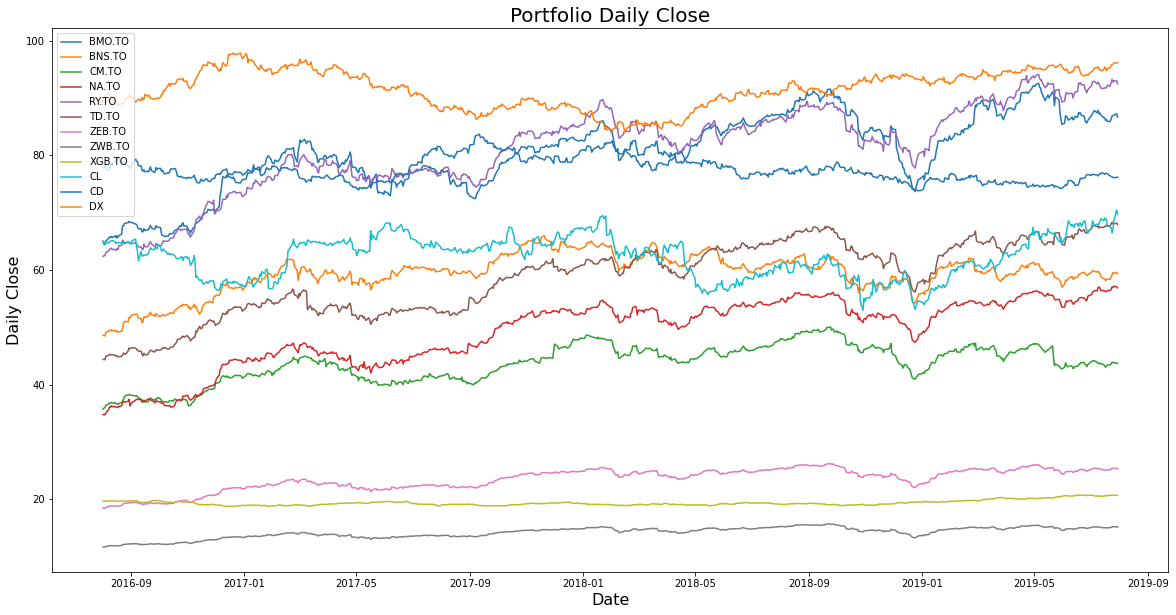

In [ ]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(all_stocks_df)
plt.title("Portfolio Daily Close", fontsize = 20)
plt.ylabel("Daily Close", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_df.columns)

plt.show()


### 3. Daily Returns

In [ ]:
# Calculate Daily Returns
# Drop nulls
all_stocks_returns_df = all_stocks_df.pct_change().dropna().copy()

#Shorten the column names
#all_stocks_returns_df.columns = ["ZEB","ZWB","RY","TD"]

# Display sample data
all_stocks_returns_df.head()

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2016-08-03,-0.003023,-0.000761,0.004615,0.001585,0.001907,-0.000356,0.000868,0.000609,-0.001319,-0.010552,0.000770,0.006001
2016-08-04,-0.004124,-0.001676,0.001939,-0.002486,0.000127,-0.001068,-0.002169,-0.001215,0.003522,0.009449,0.005002,0.002133
2016-08-05,0.009135,0.012823,0.012226,0.008836,0.008376,0.013723,0.010430,0.009124,-0.003072,-0.002674,-0.011103,0.004645
2016-08-08,0.007725,0.004823,0.004529,0.017516,0.005160,0.002813,0.008173,0.007233,0.000880,-0.002011,-0.000516,0.002251
2016-08-09,0.003713,0.003450,0.006513,0.012360,0.004382,0.004734,0.005973,0.004788,0.003078,0.004702,0.002324,-0.002290


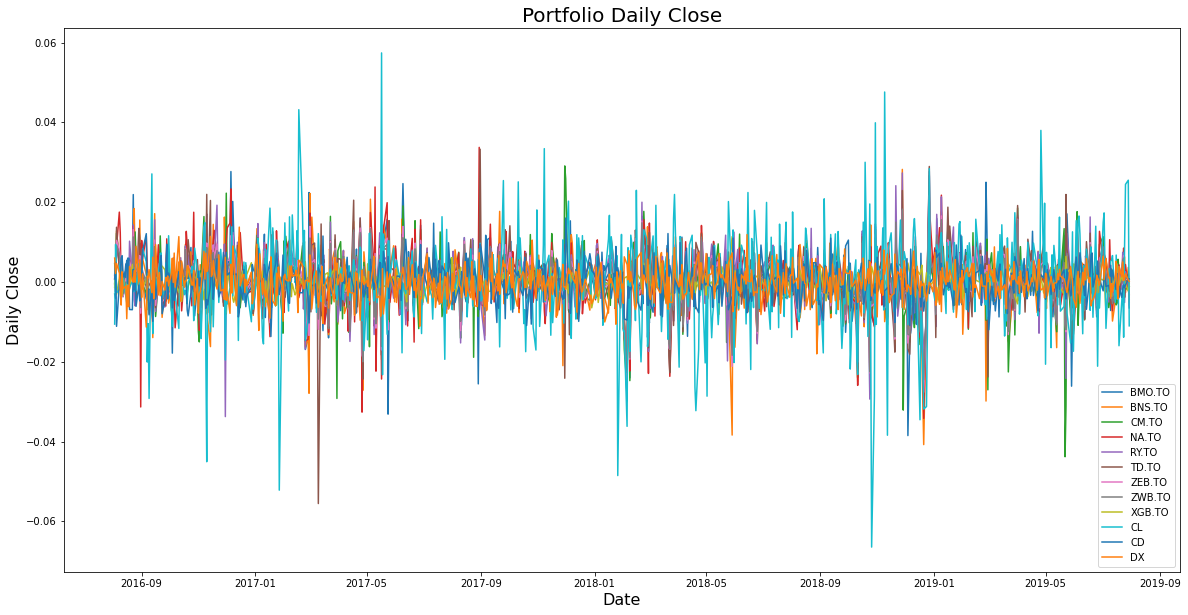

In [ ]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(all_stocks_returns_df)
plt.title("Portfolio Daily Close", fontsize = 20)
plt.ylabel("Daily Close", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_returns_df.columns)

plt.show()


### 4. Cumulative Daily Returns

In [ ]:
# Calculate cumulative returns of all portfolios
all_stocks_cumulative_returns = (1 + all_stocks_returns_df).cumprod()

# Display sample data
all_stocks_cumulative_returns.tail()      

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2019-07-24,1.338235,1.217300,1.228540,1.640488,1.494772,1.538300,1.378833,1.303511,1.053564,1.021575,0.979077,1.070785
2019-07-25,1.338772,1.224921,1.227712,1.637156,1.487087,1.532347,1.376919,1.302098,1.053706,1.030891,0.977665,1.071903
2019-07-26,1.340783,1.221630,1.225346,1.644332,1.490930,1.532545,1.377876,1.303511,1.053233,1.056115,0.976959,1.074127
2019-07-29,1.344270,1.226133,1.224282,1.641257,1.490930,1.535522,1.378836,1.304575,1.050870,1.083059,0.977665,1.074630
2019-07-30,1.335553,1.220591,1.222862,1.636131,1.482107,1.529768,1.373075,1.298188,1.050397,1.071163,0.978435,1.074775


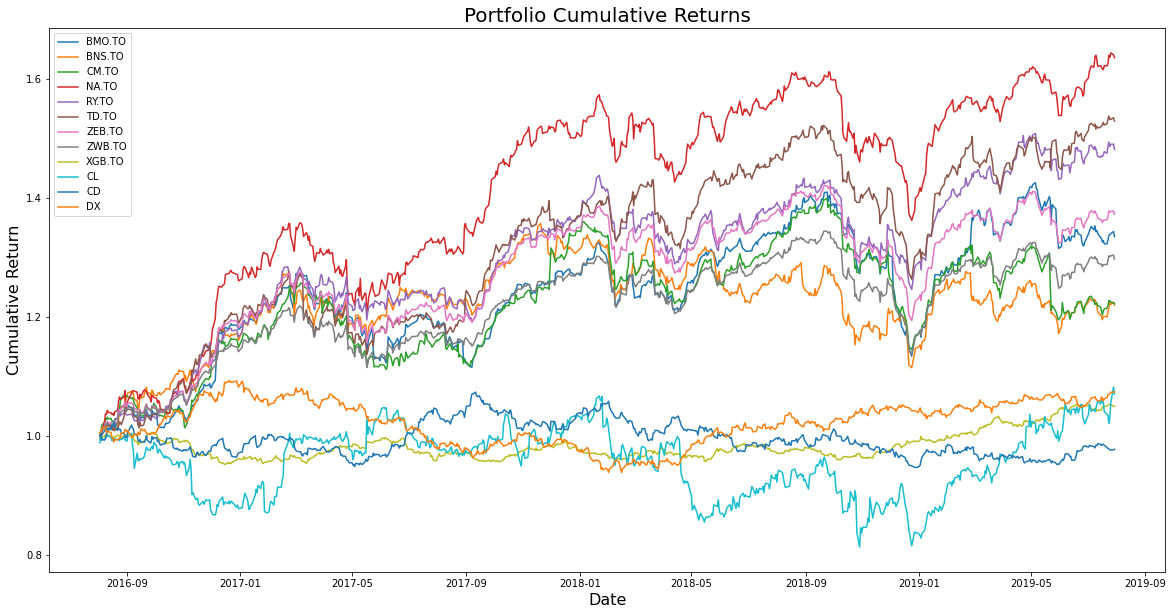

In [ ]:
# Plot cumulative returns
fig = plt.figure(figsize=(20,10))

plt.plot(all_stocks_cumulative_returns)
plt.title("Portfolio Cumulative Returns", fontsize = 20)
plt.ylabel("Cumulative Return", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_cumulative_returns.columns)

plt.show()

### 5. Box Plot - Daily Returns

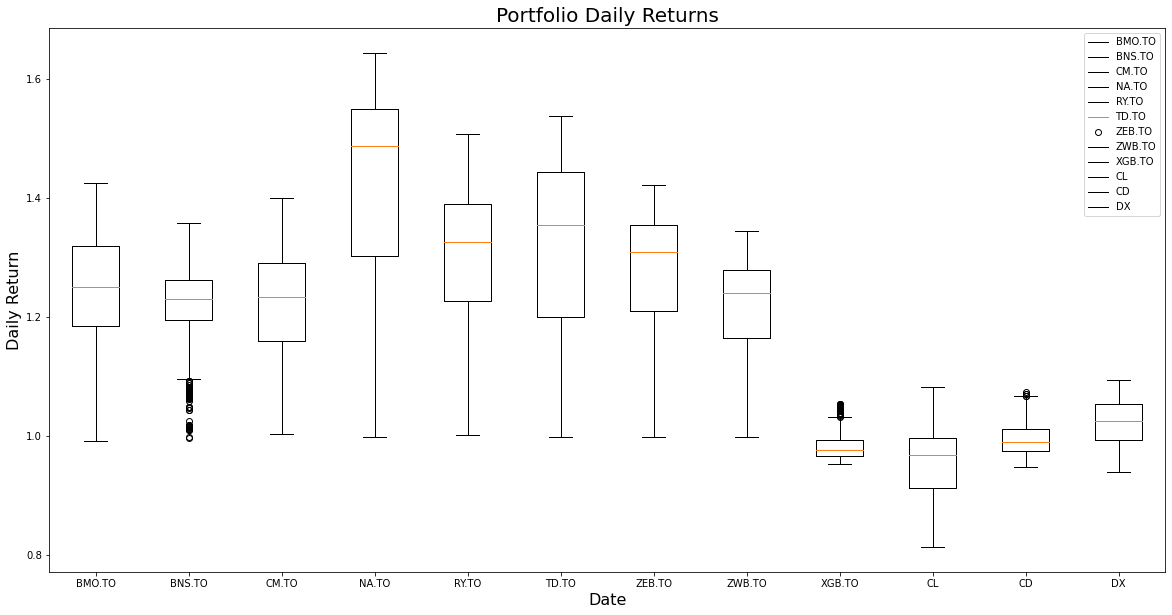

In [ ]:
# Box plot to visually show risk
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

plt.boxplot(all_stocks_cumulative_returns)
plt.title("Portfolio Daily Returns", fontsize = 20)
plt.ylabel("Daily Return", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_cumulative_returns.columns)
ax.set_xticklabels(all_stocks_cumulative_returns.columns)

plt.show()

### 6. Calculate and plot rolling `std` with 21-day window

In [ ]:
# Calculate rolling standard deviation
rolling_std_21 = all_stocks_cumulative_returns.rolling(21).std().dropna().sort_index()

# Display sample data
rolling_std_21.head()

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2016-08-31,0.020017,0.019772,0.019769,0.020733,0.012534,0.011230,0.016478,0.014152,0.001950,0.002909,0.008496,0.007509
2016-09-01,0.020012,0.020886,0.019581,0.018773,0.011564,0.011744,0.016153,0.013771,0.001987,0.002660,0.008571,0.007536
2016-09-02,0.019282,0.021868,0.019020,0.016027,0.010276,0.011909,0.015387,0.013041,0.001969,0.002748,0.008563,0.007581
2016-09-06,0.018672,0.023246,0.018849,0.014303,0.009616,0.012590,0.015129,0.012801,0.001963,0.003378,0.008361,0.007414
2016-09-07,0.018296,0.024481,0.018785,0.014324,0.009132,0.012915,0.015182,0.012848,0.002110,0.004194,0.007725,0.006953


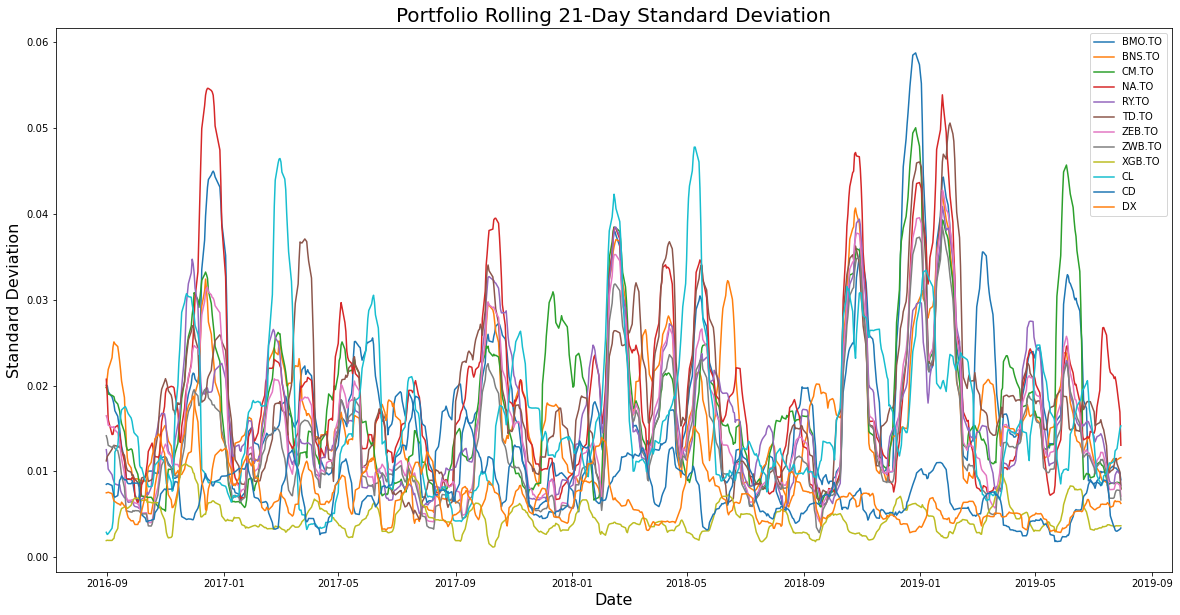

In [ ]:
# Plot rolling standard deviation
fig = plt.figure(figsize=(20,10))

plt.plot(rolling_std_21)
plt.title("Portfolio Rolling 21-Day Standard Deviation", fontsize = 20)
plt.ylabel("Standard Deviation", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(rolling_std_21.columns)

plt.show()

### 7. Calculate and plot the correlation

In [ ]:
# Calculate and plot the correlation
correlation = all_stocks_cumulative_returns.corr()

# Display Correlation Matrix
correlation

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
BMO.TO,1.000000,0.659127,0.910983,0.935662,0.947905,0.938897,0.961453,0.965779,0.230828,-0.034693,-0.178247,0.138041
BNS.TO,0.659127,1.000000,0.748687,0.744883,0.710399,0.654998,0.791352,0.775870,-0.211750,0.132653,0.347274,-0.348836
CM.TO,0.910983,0.748687,1.000000,0.898577,0.858514,0.877468,0.940924,0.943748,-0.059881,-0.122484,0.026464,-0.100488
NA.TO,0.935662,0.744883,0.898577,1.000000,0.972705,0.979912,0.986415,0.982301,0.222380,-0.021962,-0.010516,-0.070557
RY.TO,0.947905,0.710399,0.858514,0.972705,1.000000,0.961576,0.971079,0.966176,0.345380,0.087248,-0.121827,0.036585
TD.TO,0.938897,0.654998,0.877468,0.979912,0.961576,1.000000,0.968187,0.970793,0.286886,-0.078462,-0.114819,0.017374
ZEB.TO,0.961453,0.791352,0.940924,0.986415,0.971079,0.968187,1.000000,0.997852,0.153262,-0.014270,-0.017328,-0.050708
ZWB.TO,0.965779,0.775870,0.943748,0.982301,0.966176,0.970793,0.997852,1.000000,0.154177,-0.022676,-0.021232,-0.036636
XGB.TO,0.230828,-0.211750,-0.059881,0.222380,0.345380,0.286886,0.153262,0.154177,1.000000,0.397256,-0.495495,0.364977
CL,-0.034693,0.132653,-0.122484,-0.021962,0.087248,-0.078462,-0.014270,-0.022676,0.397256,1.000000,0.231472,-0.195430


<AxesSubplot:>

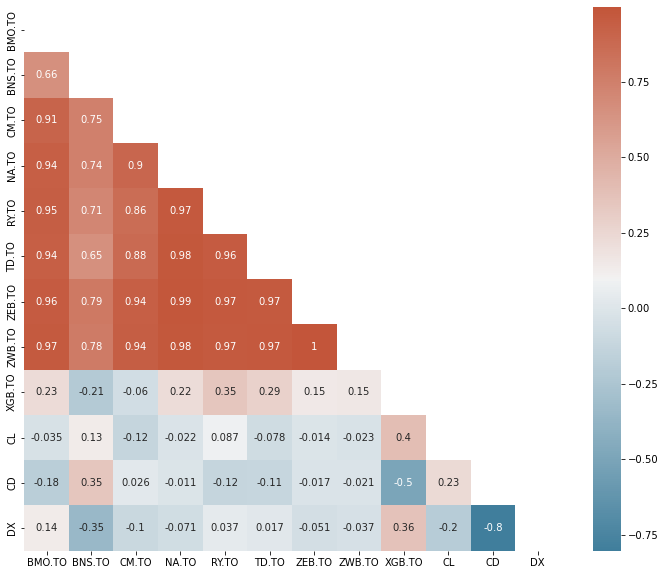

In [ ]:
# Correlation between different variables
corr = all_stocks_cumulative_returns.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# Reference: https://vitalflux.com/correlation-heatmap-with-seaborn-pandas/

### 8. Calculate and Plot the 60-day Rolling Beta for Your Portfolio compared to the S&P 60 TSX

In [ ]:
zeb_beta = all_stocks_cumulative_returns['XGB.TO']
zeb_beta

Date
2016-08-03    0.998681
2016-08-04    1.002199
2016-08-05    0.999121
2016-08-08    1.000000
2016-08-09    1.003078
                ...   
2019-07-24    1.053564
2019-07-25    1.053706
2019-07-26    1.053233
2019-07-29    1.050870
2019-07-30    1.050397
Name: XGB.TO, Length: 736, dtype: float64

In [ ]:
# Calculate and plot Beta

# Calculate covariance of a single portfolio
bmo_covariance_roll_21 = all_stocks_cumulative_returns['BMO.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
bns_covariance_roll_21 = all_stocks_cumulative_returns['BNS.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
cm_covariance_roll_21 = all_stocks_cumulative_returns['CM.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
na_covariance_roll_21 = all_stocks_cumulative_returns['NA.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
ry_covariance_roll_21 = all_stocks_cumulative_returns['RY.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
td_covariance_roll_21 = all_stocks_cumulative_returns['TD.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
zeb_covariance_roll_21 = all_stocks_cumulative_returns['ZEB.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
zwb_covariance_roll_21 = all_stocks_cumulative_returns['ZWB.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])

# Calculate variance of S&P TSX
zgb_60_variance_roll_21 = all_stocks_cumulative_returns["XGB.TO"].rolling(60).var()

# Computing beta
bmo_beta_roll_21 = round((bmo_covariance_roll_21/zgb_60_variance_roll_21),4)
bns_beta_roll_21 = round((bns_covariance_roll_21/zgb_60_variance_roll_21),4)
cm_beta_roll_21 = round((cm_covariance_roll_21/zgb_60_variance_roll_21),4)
na_beta_roll_21 = round((na_covariance_roll_21/zgb_60_variance_roll_21),4)
ry_beta_roll_21 = round((ry_covariance_roll_21/zgb_60_variance_roll_21),4)
td_beta_roll_21 = round((td_covariance_roll_21/zgb_60_variance_roll_21),4)
zeb_beta_roll_21 = round((zeb_covariance_roll_21/zgb_60_variance_roll_21),4)
zwb_beta_roll_21 = round((zwb_covariance_roll_21/zgb_60_variance_roll_21),4)

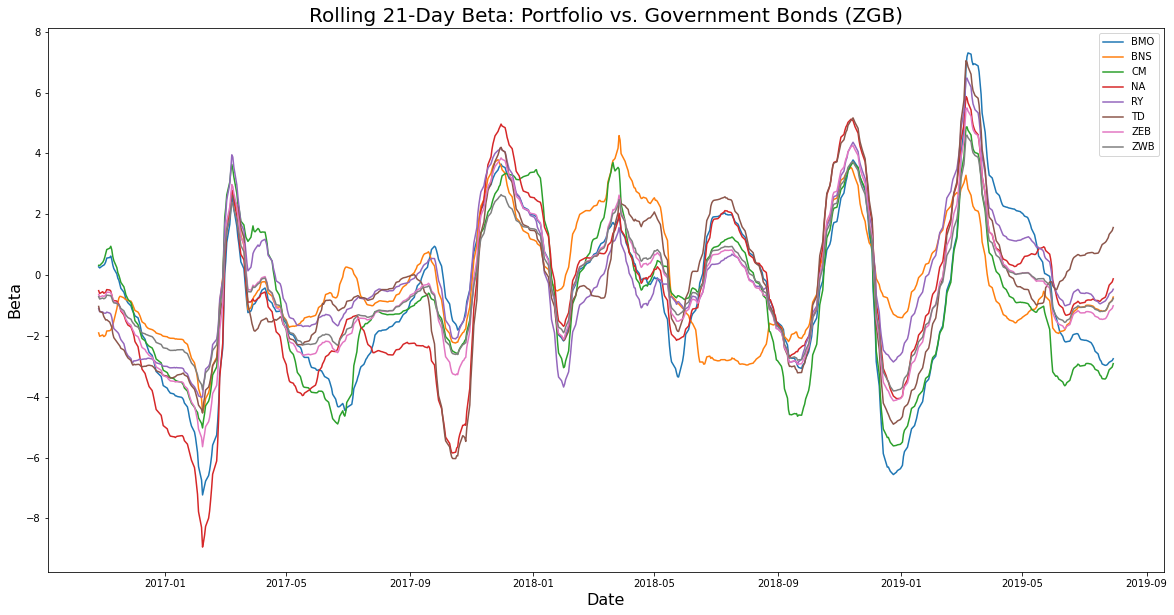

In [ ]:
# Plot beta trend
fig = plt.figure(figsize=(20,10))

plt.plot(bmo_beta_roll_21)
plt.plot(bns_beta_roll_21)
plt.plot(cm_beta_roll_21)
plt.plot(na_beta_roll_21)
plt.plot(ry_beta_roll_21)
plt.plot(td_beta_roll_21)
plt.plot(zeb_beta_roll_21)
plt.plot(zwb_beta_roll_21)
plt.title("Rolling 21-Day Beta: Portfolio vs. Government Bonds (XGB.TO)", fontsize = 20)
plt.ylabel("Beta", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(['BMO','BNS','CM','NA','RY','TD','ZEB','ZWB'])

plt.show()

### 9. Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [ ]:
# Calculate Annualized Sharpe Ratios
sharpe_ratios = pd.DataFrame((all_stocks_cumulative_returns.mean() * 252) / (all_stocks_cumulative_returns.std() * np.sqrt(252)), columns = ['Sharpe']).sort_values(by = "Sharpe")

# Display data sorted from lowest to highest risk adjusted return
sharpe_ratios.sort_values("Sharpe")

,Sharpe
NA.TO,133.945814
TD.TO,145.761442
RY.TO,169.000630
BMO.TO,192.847062
ZEB.TO,195.582256
CM.TO,213.381824
ZWB.TO,239.094018
CL,274.671301
BNS.TO,278.209997
DX,442.787635


<AxesSubplot:title={'center':'Portfolio Sharpe Ratios'}>

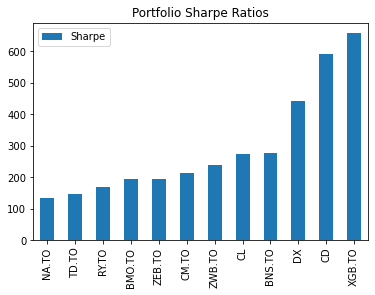

In [ ]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind = "bar", title = "Portfolio Sharpe Ratios")

## Part 2 - Retirement Planning

### Monte Carlo Simulation